# Testing out the variance subtraction method

In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


In [2]:
inners = []
for hvc_snap in master_hvcs:
    #print(hvc_snap["HVC"]["Name"])
    inner_rms, _ = KStest.split_RMs(hvc_snap["RMs"],hvc_snap["HVC"]["SkyCoord"], KStest.morph_ring(hvc_snap))
    #print(len(inner_rms), len(outer_rms))
    inners.append(inner_rms)

from astropy.table import vstack

master_rm_inner = vstack(inners)

master_rm_inner

ra_dec_obj,H-alpha flux [Error],H-alpha flux,ra_dec_deg,RM,RM_uncert,pol_int,pol_int_uncert,ra_dec_pix_offsets,interpolation_raw,interpolation_cor,interpolation_unc,interpolation_cor_unc,HI,HI [Error],pixel location x,pixel location y,B_virtual [raw],B_virtual_unc [raw],B_virtual [int],B_virtual_unc [int]
"deg,deg",R,R,,rad / m2,rad / m2,,,,rad / m2,rad / m2,rad / m2,rad / m2,dex(1 / cm2),dex(1 / cm2),,,G,G,G,G
SkyCoord,float32,float32,float64[2],float64,float64,float64,float64,float64[2],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"317.02777111652887,-7.24338741441083",0.43359375,1.9560547,317.02777111652887 .. -7.24338741441083,-40.60423996450751,1.5457592726147544,0.00043224505579967607,2.483022173816831e-05,23.9384765625 .. -3781.147460938,-18.19876746849366,-14.27570293026682,7.811525782388515,9.252382221559966,0.0,0.0,95.8395870665106,3.168123612249474,-6.171844350915965e-06,1.1291869559133162e-06,-3.4056317511422564e-06,1.6198231584449105e-06
"315.9841614286344,-8.604898582891888",0.3671875,1.3061523,315.9841614286344 .. -8.604898582891888,-17.943864127265353,0.5398814204140827,0.0011028929141821099,2.2127911789015722e-05,-1833.390625 .. -1328.559570312,-21.553376098725444,-20.719964997803352,6.932927851226972,8.7610597433037,0.0,0.0,99.34052217623503,27.393086830204084,-2.7274672926834964e-06,1.0751603398304319e-06,5.486458086665904e-07,1.5000095527147787e-06
"315.97528080367675,-8.602674548869945",0.3671875,1.3061523,315.97528080367675 .. -8.602674548869945,-20.00166869013173,2.8796117887872823,0.00020828214506339493,2.228921060452043e-05,-1849.204101562 .. -1332.516113281,-21.553376098725444,-20.719964997803352,6.932927851226972,8.7610597433037,0.0,0.0,99.44656543686574,27.42164089241487,-3.0402535799706737e-06,1.15973027144532e-06,2.3585952137941277e-07,1.560227957697956e-06
"314.8400267572668,-10.789884570172566",0.37109375,1.3300781,314.8400267572668 .. -10.789884570172566,-42.946302994027874,1.9685753167519133,0.00034087753051505095,2.493785603611105e-05,-3843.680664062 .. 2613.2734375,-23.016909214288834,-21.29075594183044,7.748767884888446,7.798476397224619,0.0,0.0,99.91571676484864,62.68235511122748,-6.527837924268638e-06,1.1488299277661995e-06,-3.02926779381115e-06,1.6217323876970382e-06
"314.9449766854099,-10.350727915633907",0.38671875,1.4951172,314.9449766854099 .. -10.350727915633907,-56.630793042608346,2.6595576349953194,0.0002455037716885602,2.4264775530082336e-05,-3663.475585938 .. 1821.873535156,-22.732926148018716,-21.884659876786948,7.873918131547356,8.110179088845562,18.02945327758789,9.014726638793945,101.07719999217477,56.363007117778125,-8.607880369966993e-06,1.2108808789242593e-06,-5.15247566471749e-06,1.6700593203193748e-06
"316.5608216074136,-7.544710711184364",0.4609375,2.2285156,316.5608216074136 .. -7.544710711184364,-24.087614309801985,1.7172058223213733,0.00035377990368995883,2.2576895086848816e-05,-809.3012695312 .. -3238.559570312,-18.984436584570815,-15.664159963818484,7.544708709018035,8.960957006560793,17.696372985839844,8.848186492919922,99.07510124245573,10.104335022399937,-3.6613173017138908e-06,1.1095542401098622e-06,-7.756829986897699e-07,1.5864273038305704e-06
"314.72900410231296,-11.781826053061165",0.35742188,1.2021484,314.72900410231296 .. -11.781826053061165,-18.70055053948933,2.610241527780946,0.0003604093244824096,3.4961126392363345e-05,-4025.90234375 .. 4398.916992188,-19.898821237690623,-18.681366401467113,7.272491084891517,7.919823432734878,0.0,0.0,96.03453816630145,76.25476868257101,-2.8424836250365127e-06,1.1437340140062546e-06,1.8213714247640817e-07,1.5847834556429165e-06
"315.0605162394619,-10.681283890192502",0.36523438,1.2875977,315.0605162394619 .. -10.681283890192502,-42.28664996671848,3.05068819648948,0.00021251602430257644,2.4093406471476396e-05,-3455.311523438 .. 2415.572509766,-21.78331130670236,-20.85182681313077,7.787866880608111,7.884041320324516,0.0,0.0,98.13114704500549,59.93437760278721,-6.427570666

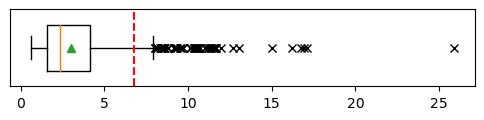

In [3]:
import numpy as np
import matplotlib.pyplot as plt

B_unc = master_rm_inner["B_virtual_unc [int]"].data * 1e6
B_true_unc = np.std(master_rm_inner["B_virtual [int]"].data * 1e6)

plt.figure(figsize=(6,1))
plt.boxplot(B_unc, vert=False, showmeans=True, widths=0.6, sym="x")
plt.axvline(B_true_unc, c='r', linestyle='--')
plt.yticks([])
plt.show()


In [12]:
from astropy.table import Table, hstack

uncert = []
for inner_rms in inners:
    m_list = inner_rms["B_virtual_unc [int]"].data * 1e6
    o_list = inner_rms["B_virtual [int]"].data * 1e6

    meas = np.mean(m_list)
    obsv = np.std(o_list)

    uncert.append({"Sigma [meas]":meas, "Sigma [obsv]":obsv, "Sigma [true]": np.sqrt(obsv**2 - meas**2)})

uncert_table = Table(uncert)
uncert_table

C:\Users\olive\AppData\Local\Temp\ipykernel_20508\3603947975.py:11: RuntimeWarning: invalid value encountered in sqrt
  uncert.append({"Sigma [meas]":meas, "Sigma [obsv]":obsv, "Sigma [true]": np.sqrt(obsv**2 - meas**2)})


Sigma [meas],Sigma [obsv],Sigma [true]
float64,float64,float64
1.5490103064419392,3.259633374868092,2.8680615072014404
1.0172162310775188,2.2736826533710723,2.033446322742001
1.3692498776485982,3.4139391636197307,3.1273207998949974
1.7766805216998156,6.285240753776755,6.028901861595415
1.390653120203451,0.6443423969361269,nan
2.5577313774843344,3.3456971641453612,2.1567799412092095
8.363070544185819,12.507923833010205,9.300925205879048
5.0791565705667105,9.744382180123484,8.315957708164293
3.023390368905306,4.983729795251348,3.9619027435421326


In [15]:
ks = ct.read_processed("../data_processed/hvc_KS_tests/hvc_KS_average")
hks = hstack([ks, uncert_table])

hks = hks[hks["Significant"]]
hks

ct.write_processed(hks, "../data_processed/results_maybe")

In [16]:
hks

Name,Statistic,p_value,Statistic_x,Statistic_sgn,Significant,Sigma [meas],Sigma [obsv],Sigma [true]
str15,float64,float64,float64,int32,bool,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,True,1.5490103064419392,3.259633374868092,2.8680615072014404
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,True,1.0172162310775188,2.2736826533710723,2.033446322742001
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,True,1.3692498776485982,3.4139391636197307,3.1273207998949974
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-3.5031459148744912,1,True,1.7766805216998156,6.285240753776755,6.028901861595415
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-1.0081759072724916,-1,True,1.390653120203451,0.6443423969361269,nan
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,True,8.363070544185819,12.507923833010205,9.300925205879048
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,True,5.0791565705667105,9.744382180123484,8.315957708164293
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,True,3.023390368905306,4.983729795251348,3.9619027435421326
G267.1-38.4+263,0.3428488020518381,2.318648482161409e-11,12.715164074377505,-1,True,6.459354538810761,13.975229335809928,12.392892072895142
